In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from nltk.corpus import stopwords

In [3]:
stop_words = stopwords.words('spanish')

In [4]:
pd.options.display.max_rows = 30

In [5]:

df_townstate = pd.read_csv('input/town_state.csv.gz', compression='gzip')
df_townstate['bimbo'] = df_townstate.Town.str.contains('BIMBO') * 1
df_townstate['ag'] = df_townstate.Town.str.contains('AG.') * 1

In [6]:
df_cliente = pd.read_csv('input/cliente_tabla.csv.gz', compression='gzip')

In [7]:
df_cliente.NombreCliente.str.contains('OXXO').sum()

9014

In [9]:
# (df_test.Cliente_ID == 2).sum()

In [10]:
def trata_producto_names(df_producto):
    from nltk.stem.snowball import SnowballStemmer

    df_producto['short_names'] = df_producto.NombreProducto.str.extract('^(\D*)')
    df_producto['short_names_processed'] = df_producto['short_names'].map(lambda x: " ".join([i for i in x.lower().split() if i not in stopwords.words('spanish')]))

    stemmer = SnowballStemmer("spanish")

    df_producto['short_names_processed'] = (df_producto['short_names_processed']
                                            .map(lambda x: " ".join([stemmer.stem(i) for i in x.lower().split()])))
    df_aux_producto = df_producto['short_names_processed'].value_counts()[df_producto['short_names_processed'].value_counts() > 10].reset_index()

    df_producto['flavor_choc'] = df_producto.short_names_processed.str.contains('choc') * 1
    df_producto['flavor_vainill'] = df_producto.short_names_processed.str.contains('vainill') * 1
    df_producto['flavor_canel'] = df_producto.short_names_processed.str.contains('canel') * 1

    df_producto['NombreProducto'] = df_producto['NombreProducto'].str.upper()
    df_producto['NombreProducto'] = df_producto.apply(lambda x :x['NombreProducto'].replace(str(x['Producto_ID']),'').strip(), axis=1 )
    df_producto = pd.DataFrame(df_producto.loc[1:])
    df_producto['fabricante'] = df_producto.NombreProducto.str.split(' ').str[-1]
    df_producto.ix[df_producto.fabricante == '1KG','fabricante'] = ''
    df_producto['NombreProducto'] = df_producto.apply(lambda x :x['NombreProducto'].replace(x['fabricante'],'').strip(), axis=1 )

    reg = '(\d{1,4}G|\d{1,4}KG|\d{1,4}ML|\d{1,4}\ ML)'
    df_producto['volume'] = df_producto.NombreProducto.str.extract(reg)

    df_producto['NombreProducto'] = df_producto.apply(lambda x :x['NombreProducto'].replace(str(x['volume']),'').replace('  ',' ').strip(), axis=1 )

    reg = '(\d{1,5}P)'
    df_producto['unidade'] = df_producto.NombreProducto.str.extract(reg)
    df_producto['NombreProducto'] = df_producto.NombreProducto.str.replace(reg, '').str.replace('  ',' ').str.strip()

    aux = pd.DataFrame({'Producto_ID':[0],'NombreProducto':['NO IDENTIFICADO']})
    df_producto = df_producto.append(aux)

    df_producto['unidade'] = df_producto.volume.str.extract('([A-Z])')
    df_producto['volume'] = df_producto.volume.str.replace('([A-Z])','')

    return df_producto

In [11]:


# df_producto

In [99]:
df_week = pd.read_csv('input/train_week3.csv')

In [103]:
df_week['mean_price'] = df_week['Venta_hoy']/df_week['Venta_uni_hoy']

In [117]:
aux.columns

Index(['Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID', 'Producto_ID',
       'Demanda_uni_equil', 'count_agencia', 'State_x', 'Venta_hoy',
       'Venta_hoy_log10', 'flavor_choc', 'flavor_vainill', 'flavor_canel',
       'volume', 'fabricante', 'ag', 'bimbo', 'State_y', 'route_client',
       'route_client_log10', 'Canal_ID1', 'volume_bin', 'Venta_hoy_bin'],
      dtype='object')

In [ ]:
plt.scatter(aux.Canal_ID1.values, aux.Demanda_uni_equil.values)

In [13]:
# df_week.Venta_uni_hoy.hist(range=(0,300), bins=50)

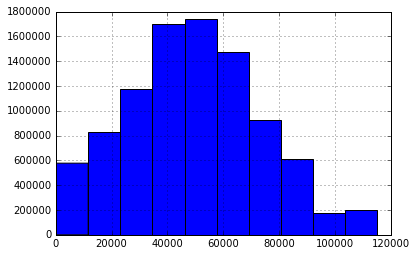

In [119]:
aux.count_agencia.hist()

gb = df_week[['Producto_ID','Venta_hoy']].groupby(['Producto_ID']).median().reset_index()
gb[gb['Venta_hoy'] == gb['Venta_hoy'].max()]
aux = df_producto.merge(gb, how='left', on='Producto_ID')
aux.ix[aux['Venta_hoy'].isnull(),'Venta_hoy'] = 0
df_producto = aux

gb = df_week[['Producto_ID','Venta_uni_hoy']].groupby(['Producto_ID']).median().reset_index()
gb[gb['Venta_uni_hoy'] == gb['Venta_uni_hoy'].max()]
aux = df_producto.merge(gb, how='left', on='Producto_ID')
aux.ix[aux['Venta_uni_hoy'].isnull(),'Venta_uni_hoy'] = 0
df_producto = aux

gb = df_week[['Producto_ID','Dev_uni_proxima']].groupby(['Producto_ID']).median().reset_index()
gb[gb['Dev_uni_proxima'] == gb['Dev_uni_proxima'].max()]
aux = df_producto.merge(gb, how='left', on='Producto_ID')
aux.ix[aux['Dev_uni_proxima'].isnull(),'Dev_uni_proxima'] = 0
df_producto = aux

In [14]:
def process_venta_producto():
    l = []
    print('week: ')
    for week in range(3,10):
        print(week, end='\r')
        df_week = pd.read_csv('input/train_week%s.csv' % week, usecols=['Producto_ID','Venta_hoy'])
        prod_venta = df_week[['Producto_ID','Venta_hoy']].groupby('Producto_ID').median().reset_index()
        l.append(prod_venta)
    df_venta = pd.concat(l)
    df_venta = df_venta.groupby('Producto_ID').median().reset_index()
    df_venta['Venta_hoy_log10'] = np.round(np.log10(df_venta['Venta_hoy'].values + 1))
    return df_venta

In [15]:
def process_venta_agencia(df_townstate):
    l = []
    print('week: ')
    for week in range(3,10):
        print(week, end='\r')
        df_week = pd.read_csv('input/train_week%s.csv' % week, usecols=['Agencia_ID','Venta_hoy'])
        aux = df_week.merge(df_townstate, how='left', on='Agencia_ID')
        prod_venta = aux.groupby('State').median().reset_index()
        l.append(prod_venta)
    df_venta = pd.concat(l)
    df_venta = df_venta[['Agencia_ID','Venta_hoy','State']].groupby('State').median().reset_index()
    df_venta['Venta_hoy_log10'] = np.round(np.log(df_venta['Venta_hoy'].values+1))
    return df_venta

In [16]:
def process_producto():
    df_producto = pd.read_csv('input/producto_tabla.csv.gz', compression='gzip')
    df_producto = trata_producto_names(df_producto)
    return df_producto

In [17]:
def count_agencia():
    l = []
    print('week: ')
    for week in range(3,10):
        print(week, end='\r')
        df_week = pd.read_csv('input/train_week%s.csv' % week, usecols=['Agencia_ID','Cliente_ID'])
        prod_venta = df_week.groupby('Agencia_ID').count().reset_index()
        l.append(prod_venta)
    prod_venta = pd.concat(l)    
    prod_venta = prod_venta.groupby('Agencia_ID').mean().reset_index()
    prod_venta['count_agencia'] = prod_venta['Cliente_ID']
    prod_venta['Agencia_ID'] = prod_venta['Agencia_ID'].astype(int)
    return prod_venta[['Agencia_ID','count_agencia']]

In [18]:
df_producto = process_producto()
df_venta = process_venta_producto()

# df_venta = df_venta.ix[a & b]

week: 


In [19]:
df_venta_agencia = process_venta_agencia(df_townstate)

week: 


In [20]:
df_count_agencia = count_agencia()

week: 


In [21]:
def count_entregas(df, by):
    df['entregas_'+by] = 1
    aux = df.groupby([by]).agg({"entregas_"+by:np.size}).reset_index()
    df.drop('entregas_'+by, axis=1, inplace=True)
    return df.merge(aux, how='left', on=by)

In [22]:
def binarize(df, field, length, step):
    df[field+'_bin']='undefined'
    df[field] = df[field].astype(float)
    for x in range(step, length, step):
        a = df[field] > x - step
        b = df[field] <= x
        f = a & b
        value = '%s-%s' % (x-step, x)
        df.ix[f, field+'_bin'] = value
    print(field+'_bin')
    return df

In [85]:
def process_df(df, test=False):
    
    if not test:
#         df = df.drop(['Venta_uni_hoy','Venta_hoy','Dev_uni_proxima'], axis=1)
        df = df.ix[df.Producto_ID != 0]
        df = df.ix[df.Demanda_uni_equil<20]
        
    df = df.merge(df_count_agencia, on='Agencia_ID', how='left')
    df['count_agencia'] = df['count_agencia'].fillna(df['count_agencia'].median())
    df = df.merge(df_venta_agencia, how='left', on='Agencia_ID')
    print (df.columns)
    print('')
    df = df.merge(df_producto[['flavor_choc', 'flavor_vainill', 'flavor_canel','volume', 'fabricante','Producto_ID']], how='left',on='Producto_ID')
    df = df.merge(df_townstate[['Agencia_ID','ag','bimbo','State']], on='Agencia_ID', how='left')
    df.volume = df.volume.fillna(0).astype('int')

    route_count = df[['Cliente_ID','Ruta_SAK']].groupby(['Cliente_ID']).count().reset_index()
    route_count.columns = ['Cliente_ID','route_client']
    route_count = route_count.ix[route_count['route_client'] <= 60]
    df = df.merge(route_count, how='left', on='Cliente_ID')
    df = df.ix[~df['route_client'].isnull()]
    df['route_client_log10'] = np.log10(df['route_client'].values+1)
    
    df = df.ix[df.volume<500]
        
    df['Cliente_ID'] = df['Cliente_ID'].astype('str')
    df['Agencia_ID'] = df['Agencia_ID'].astype('str')
    df['Canal_ID1'] = (df['Canal_ID']==1)*1
    df['Ruta_SAK'] = df['Ruta_SAK'].astype('str')
        
#     f = (df['volume'] < 200)
#     df = df.ix[f]
#     df['volume_bin'] = pd.cut(df.volume.values, 6)
    df['volume_bin'] = (df['volume'] <= 100)*1
    
#     f = (df['Venta_hoy_log10'] <=6 )
#     df = pd.DataFrame(df.ix[f])
#     df = binarize(df, 'Venta_hoy_log10', 6, 1)
    df['Venta_hoy_bin'] = pd.cut(df.Venta_hoy.values, 6)

#     f = (df['Venta_uni_hoy'] < 10)
#     df = pd.DataFrame(df.ix[f])
#     df = binarize(df, 'Venta_uni_hoy', 10, 2)
    
#     a = df['Venta_uni_hoy_bin'] == ''
#     b = df['Venta_hoy_bin'] == ''
#     c = df['volume_bin'] == ''
#     df = df.ix[~c]
    
        
#     y = df['Demanda_uni_equil'].values
#     x = pd.get_dummies(aux[cols]).values
#   x = pd.get_dummies(aux[cols]).values
    return df

In [86]:
# df_process['fabricante'].value_counts()

In [87]:
cols = [
#     'volume',
#     'entregas_Producto_ID',
#     'Cliente_ID',
#     'entregas_fabricante',
#     'Agencia_ID',
    'route_client_log10',
    'Canal_ID1',
#     'fabricante',
#     'Venta_uni_hoy_bin',
#     'Venta_hoy_bin',
#     'Venta_hoy_log10',
#     'short_names_processed',
#     'State',
    'count_agencia',
    'volume_bin',
#     'ag',
#     'bimbo',
    'flavor_choc',
    'flavor_vainill',
    'flavor_canel',
]

In [88]:
# aux.Agencia_ID.dtype 

In [89]:
# df_count_agencia['Agencia_ID'].dtype

In [62]:
# a.agencia_count.max()

In [63]:
# aux.Agencia_ID.dtypes

In [64]:
# df_count_agencia.Agencia_ID.dtype

In [65]:
# df_week.merge(df_count_agencia, on='Agencia_ID', how='left')

In [32]:
# aux.Canal_ID.value_counts().plot(kind='bar')

In [33]:
# aux.Venta_hoy.hist(bins=7)


In [34]:
# aux.shape

In [35]:
# enc._n_values

# fiitting model

In [90]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [91]:
# rf = ExtraTreesRegressor(n_estimators=50, max_features=1.0,min_samples_split=3,n_jobs=4)



def train(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=1729)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    print(mean_squared_error(y_test, y_pred))
        

In [92]:
# df.columns

In [93]:
rf = RandomForestRegressor(n_jobs=4) #, random_state=401

for week in range(3,10):
    df_week = pd.read_csv('input/train_week%s.csv' % week, usecols=['Agencia_ID','Ruta_SAK','Cliente_ID','Canal_ID','Producto_ID','Demanda_uni_equil'])

    aux = process_df(df_week)
    df = aux[cols+['Demanda_uni_equil']].iloc[np.random.permutation(len(aux))]
    df = pd.get_dummies(df)

    print('fitting...')
    # for x in range(10000,df.shape[0]-10000,10000):
    df_partial = df
    x = df_partial.drop(['Demanda_uni_equil'], axis=1).values
    y = df_partial['Demanda_uni_equil'].values
    train(x,y)
    break

Index(['Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID', 'Producto_ID',
       'Demanda_uni_equil', 'count_agencia', 'State', 'Venta_hoy',
       'Venta_hoy_log10'],
      dtype='object')

fitting...
11.3215266961


In [ ]:
11.32

# testing feature importances

In [94]:
a = pd.get_dummies(aux[cols])

In [95]:
rf.feature_importances_.shape

(7,)

In [96]:
# a.columns

In [97]:
a.columns[:]

Index(['route_client_log10', 'Canal_ID1', 'count_agencia', 'volume_bin',
       'flavor_choc', 'flavor_vainill', 'flavor_canel'],
      dtype='object')

<Container object of 7 artists>

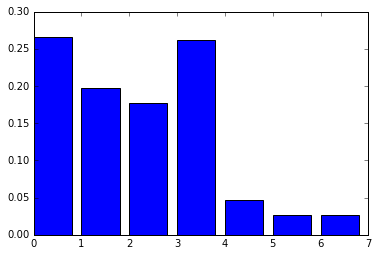

In [98]:
plt.bar(range(0,7), height=rf.feature_importances_)

In [ ]:
# aux.Demanda_uni_equil.value_counts().plot(kind='bar')

In [ ]:
aux.columns

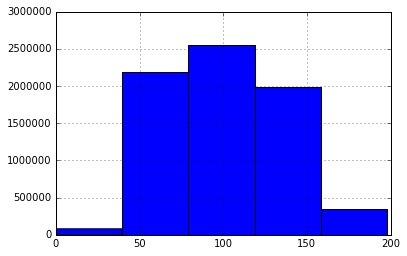

In [ ]:
df_test

In [38]:
df_test = pd.read_csv('input/test.csv.gz', compression='gzip')

In [ ]:
df = process_df(df_test, test=True)
# df = aux.iloc[np.random.permutation(len(aux))]
df = pd.get_dummies(df)
res = rf.predict(df.values)

In [ ]:
a = df_test.merge(df_producto, how='left', on='Producto_ID')

In [ ]:
a.Venta_uni_hoy.hist(range=(0,10), bins=2)

In [ ]:
# df_process['short_names_processed']

In [ ]:
# pd.get_dummies(df_process[0:100][cols])

In [ ]:
f = plt.subplots()
i = 444
for v in x.T:
    i+=1
    f.hist(v)

In [ ]:
df.columns

In [ ]:
count_entregas(df, 'Agencia_ID')